In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import os
from scipy.stats import t
from scipy import stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import skew

# **Preprocessing data**

In [2]:
os.getcwd()

'd:\\DOWNLOADS\\GIT Repo\\Used-Car-Price-Prediction\\src'

In [3]:
import pandas as pd
import requests
from io import BytesIO

url = 'https://github.com/haingocnguyen/Used-Car-Price-Prediction/raw/main/data/CarPrice_Assignment.xlsx'

# Request the content of the file from the URL
response = requests.get(url)
file_content = BytesIO(response.content)

# Read the content with pandas
df = pd.read_excel(file_content)

df.head()


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Drop the column "car_ID"

In [5]:
del df['car_ID']

Change the dtype of attribute "**symboling**" to consider it as categorical data

In [6]:
df['symboling'] = df['symboling'].astype("object")

In [7]:
df['price'] = df['price'].astype("int64")

In [8]:
df.dtypes

symboling            object
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price                 int64
dtype: object

Divide the data into two DataFrames: one for categorical data and another for quantitative data.

In [9]:
# Split the DataFrame based on data types
df1 = df.select_dtypes(include=['object'])
df2 = df.select_dtypes(include=['float64', 'int64'])
df1.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi


The file df2 dataframe includes 13 attributes consisting of quantitative data, along with a target variable, which is the price.

In [10]:
df2.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


**We are attempting to identify the two attributes that most significantly influence the price.**

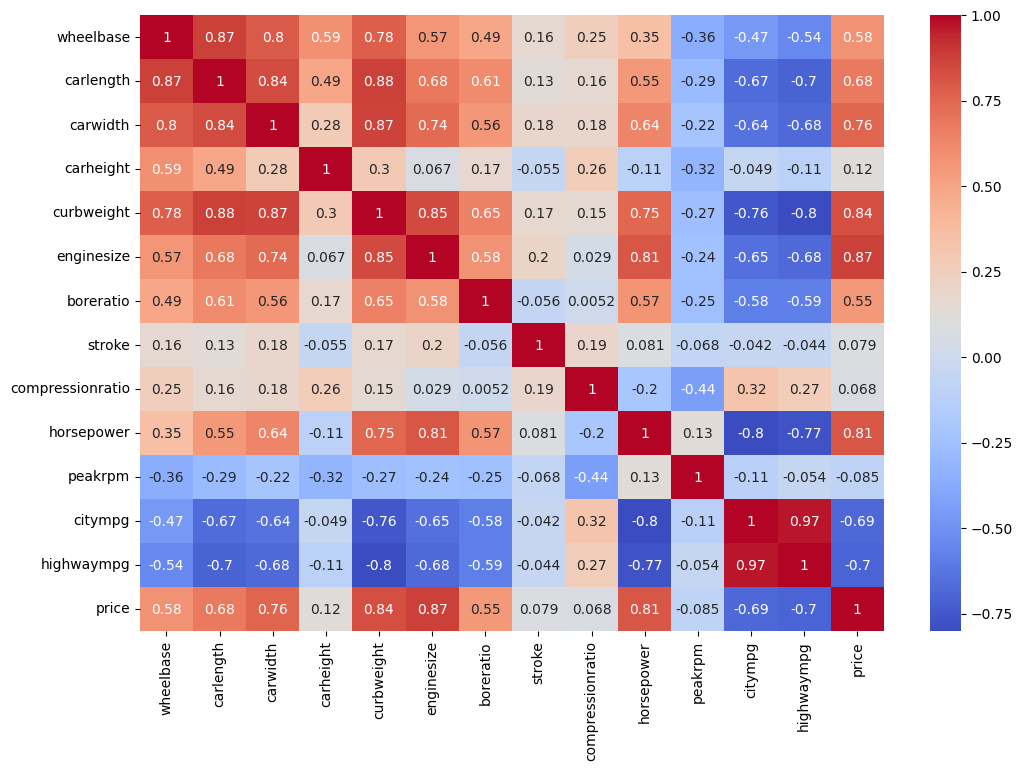

In [11]:
# Correlogram
correlation_matrix = df2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# **EDA**

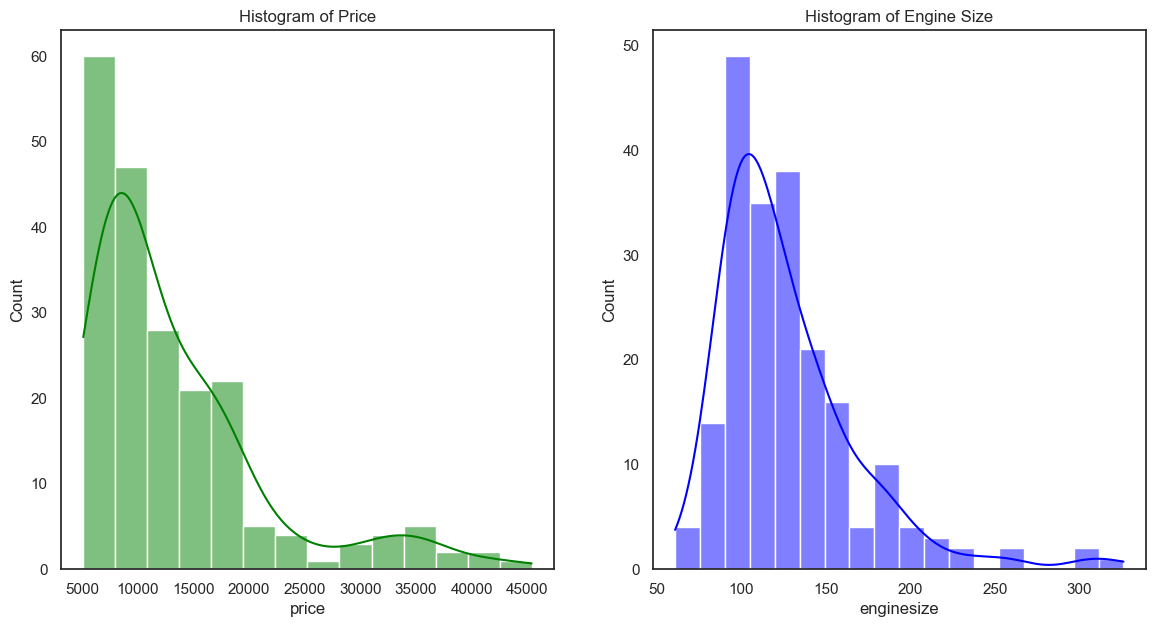

In [12]:
# Distribution of the enginesize and price
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  

sns.histplot(df2['price'], kde=True, ax=axes[0], color='green') 
axes[0].set_title('Histogram of Price')

sns.histplot(df2['enginesize'], kde=True, ax=axes[1], color='blue') 
axes[1].set_title('Histogram of Engine Size')

plt.show()

## **Check for outliers**

Define a function to detect outliers and summary metrics

In [13]:
def detect_print_outliers(df, var):
    # Define a function to detect outliers in a single variable
    def find_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        outliers = series[(series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))]
        return outliers

    # Detect outliers in both variables
    outliers = find_outliers(df[var])

    # Print the results
    print(f"Outliers in {var}:\n")
    print(outliers)

# Calculate five-number summary for 'price'
price_summary = df2['price'].describe()
price_five_number_summary = {
    'Minimum': price_summary['min'],
    'First Quartile (Q1)': price_summary['25%'],
    'Median': price_summary['50%'],
    'Third Quartile (Q3)': price_summary['75%'],
    'Maximum': price_summary['max']
}

# Calculate five-number summary for 'enginesize'
enginesize_summary = df2['enginesize'].describe()
enginesize_five_number_summary = {
    'Minimum': enginesize_summary['min'],
    'First Quartile (Q1)': enginesize_summary['25%'],
    'Median': enginesize_summary['50%'],
    'Third Quartile (Q3)': enginesize_summary['75%'],
    'Maximum': enginesize_summary['max']
}

### **`Price`**

In [14]:
# Print the measures and outliers in 'price'
print(f"Five-Number Summary for Price: \n{price_five_number_summary}")
# Boxplot for 'price'
fig_price = go.Figure()
fig_price.add_trace(go.Box(x=df2['price'], name='Summary',boxmean=True, marker_color = 'green'))

fig_price.update_layout(
    title="Boxplot of Price",
    xaxis_title="Price",
)
fig_price.show()
detect_print_outliers(df2, 'price')

Five-Number Summary for Price: 
{'Minimum': 5118.0, 'First Quartile (Q1)': 7788.0, 'Median': 10295.0, 'Third Quartile (Q3)': 16503.0, 'Maximum': 45400.0}


Outliers in price:

15     30760
16     41315
17     36880
47     32250
48     35550
49     36000
70     31600
71     34184
72     35056
73     40960
74     45400
126    32528
127    34028
128    37028
129    31400
Name: price, dtype: int64


### **`Enginesize`**

In [15]:
# Print the measures and outliers in 'enginesize'
print(f"Five-Number Summary for Enginesize: \n{enginesize_five_number_summary}")
# Boxplot for 'enginesize'
fig_engine = go.Figure()
fig_engine.add_trace(go.Box(x=df2['enginesize'], name="Summary", boxmean=True, marker_color= 'blue'))

fig_price.update_layout(
    title="Boxplot of Enginsize",
    xaxis_title="Enginesize",
)
fig_engine.show()
detect_print_outliers(df2, 'enginesize')

Five-Number Summary for Enginesize: 
{'Minimum': 61.0, 'First Quartile (Q1)': 97.0, 'Median': 120.0, 'Third Quartile (Q3)': 141.0, 'Maximum': 326.0}


Outliers in enginesize:

15    209
16    209
17    209
47    258
48    258
49    326
71    234
72    234
73    308
74    304
Name: enginesize, dtype: int64


## **Conclusion**

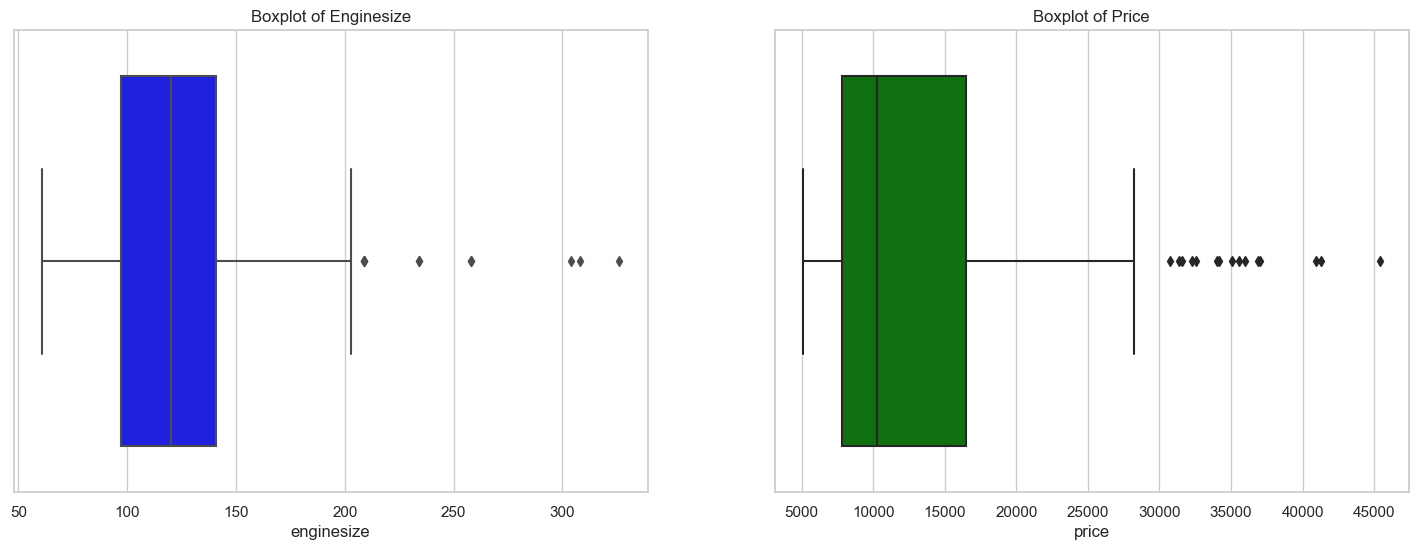

In [16]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram and boxplot for 'price'
sns.boxplot(x=df2['enginesize'], ax=axes[0], color="blue")
axes[0].set_title('Boxplot of Enginesize')
sns.boxplot(x=df2['price'], ax=axes[1], color="green")
axes[1].set_title('Boxplot of Price')

plt.show()

- The boxplot for the `price` variable show that the distribution is right-skewed, with several outliers on the higher end. These outliers represent cars that are significantly more expensive than the majority. In the context of car pricing, these outliers could be meaningful as they might represent luxury or high-performance vehicles that naturally have higher prices. Removing them could skew the understanding of the high-end car market.

- The boxplot for the `enginsize` is also right-skewed, with some outliers present on the higher end. Similar to the `price` variable, these outliers in `enginsize` might be meaningful as they likely represent vehicles with high-performance engines, which are a significant aspect of certain segments of the automotive market (such as sports cars or luxury vehicles). Retaining these outliers could be important for a comprehensive analysis, as excluding them might omit insights into this niche but important part of the market.

# **Linear Regression model**

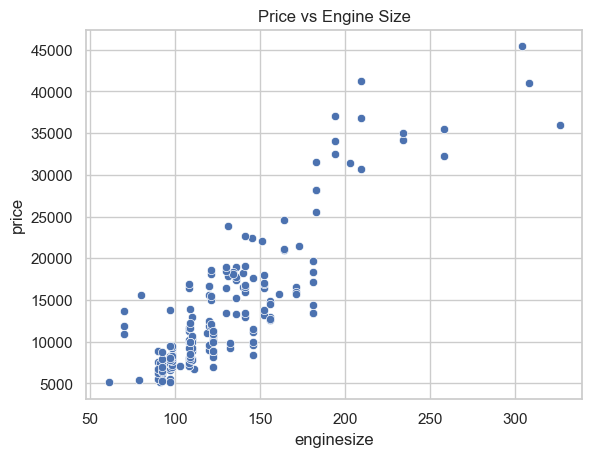

In [17]:
# Scatter plots
sns.set(style="whitegrid")
sns.scatterplot(x='enginesize', y='price', data=df2)
plt.title('Price vs Engine Size')
plt.show()


**Fit linear regression model**

In [18]:
import pandas as pd
import statsmodels.api as sm

# Selecting the independent variables and adding a constant term for the intercept
X = sm.add_constant(df2['enginesize']) 
y = df2['price']
# Fit the regression model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     657.6
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.35e-65
Time:                        00:54:17   Log-Likelihood:                -1984.4
No. Observations:                 205   AIC:                             3973.
Df Residuals:                     203   BIC:                             3979.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8005.4530    873.219     -9.168      0.0

**Least-squared regression function**

In [19]:
#Print the regression equation
coefficients = model.params
print(f"Price = {coefficients['const']:.2f} + {coefficients['enginesize']:.2f}*enginesize")

Price = -8005.45 + 167.70*enginesize


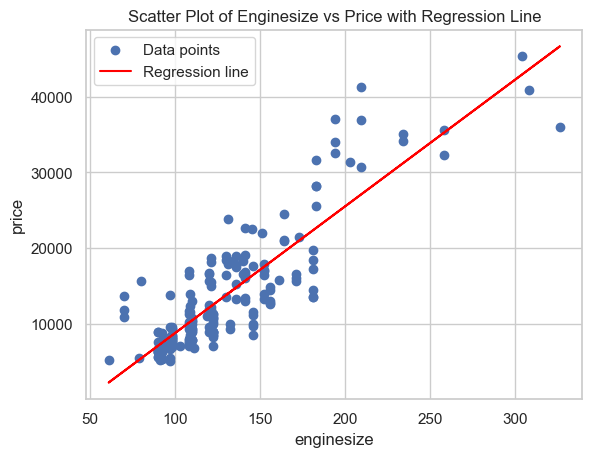

In [20]:
y_hat = model.predict()
sns.set(style="whitegrid") 
plt.scatter(df2['enginesize'], df2['price'], label='Data points')
plt.plot(df2['enginesize'], y_hat, color='red', label='Regression line')
plt.xlabel('enginesize')
plt.ylabel('price')
plt.title('Scatter Plot of Enginesize vs Price with Regression Line')
plt.legend()
plt.show()


In [21]:
# Compute correlation coefficients
correlation_enginesize_price = df2['enginesize'].corr(df2['price'])
print(f"Correlation coefficient between Enginesize and Price: {correlation_enginesize_price:.3f}")


Correlation coefficient between Enginesize and Price: 0.874



**Check for assumptions**

In [58]:
# Obtain the residuals
residuals = model.resid

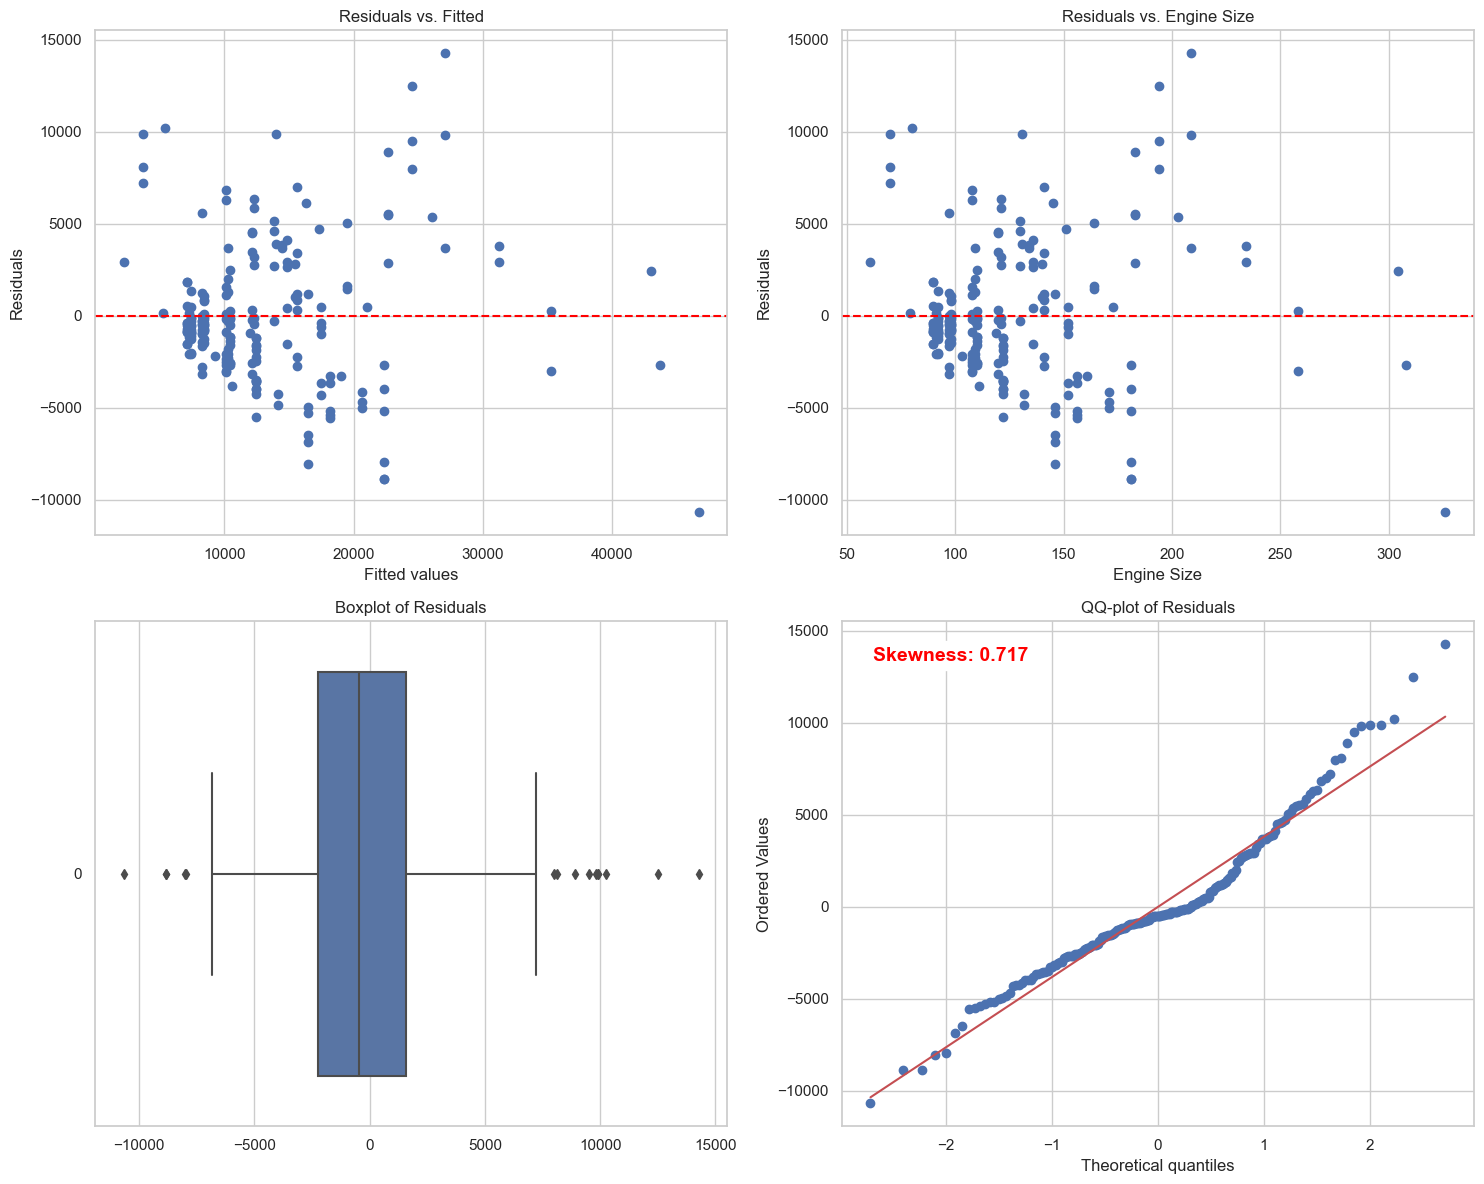

In [60]:
# Plotting for regression diagnostics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot between residuals and fitted values
axes[0, 0].scatter(model.fittedvalues, model.resid)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs. Fitted')

# 2. Scatter plot between enginesize and residuals
axes[0, 1].scatter(df2['enginesize'], model.resid)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Engine Size')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs. Engine Size')

# 3. Boxplot of residuals
sns.boxplot(model.resid, ax=axes[1, 0], orient='h')
axes[1, 0].set_title('Boxplot of Residuals')

# 4. QQ-plot of residuals to check normality
resi_skew = skew(residuals)
stats.probplot(residuals, dist="norm", plot=plt)
plt.annotate('Skewness: {:.3f}'.format(resi_skew), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, 
             horizontalalignment='left', verticalalignment='top', fontweight='bold', color='red', backgroundcolor='white')
axes[1, 1].set_title('QQ-plot of Residuals')

plt.tight_layout()
plt.show()

In [61]:
# Apply Box-Cox transformation to the 'price' to normalize it
price_transformed, fitted_lambda = boxcox(df2['price'])
fitted_lambda


-0.6280831814761029

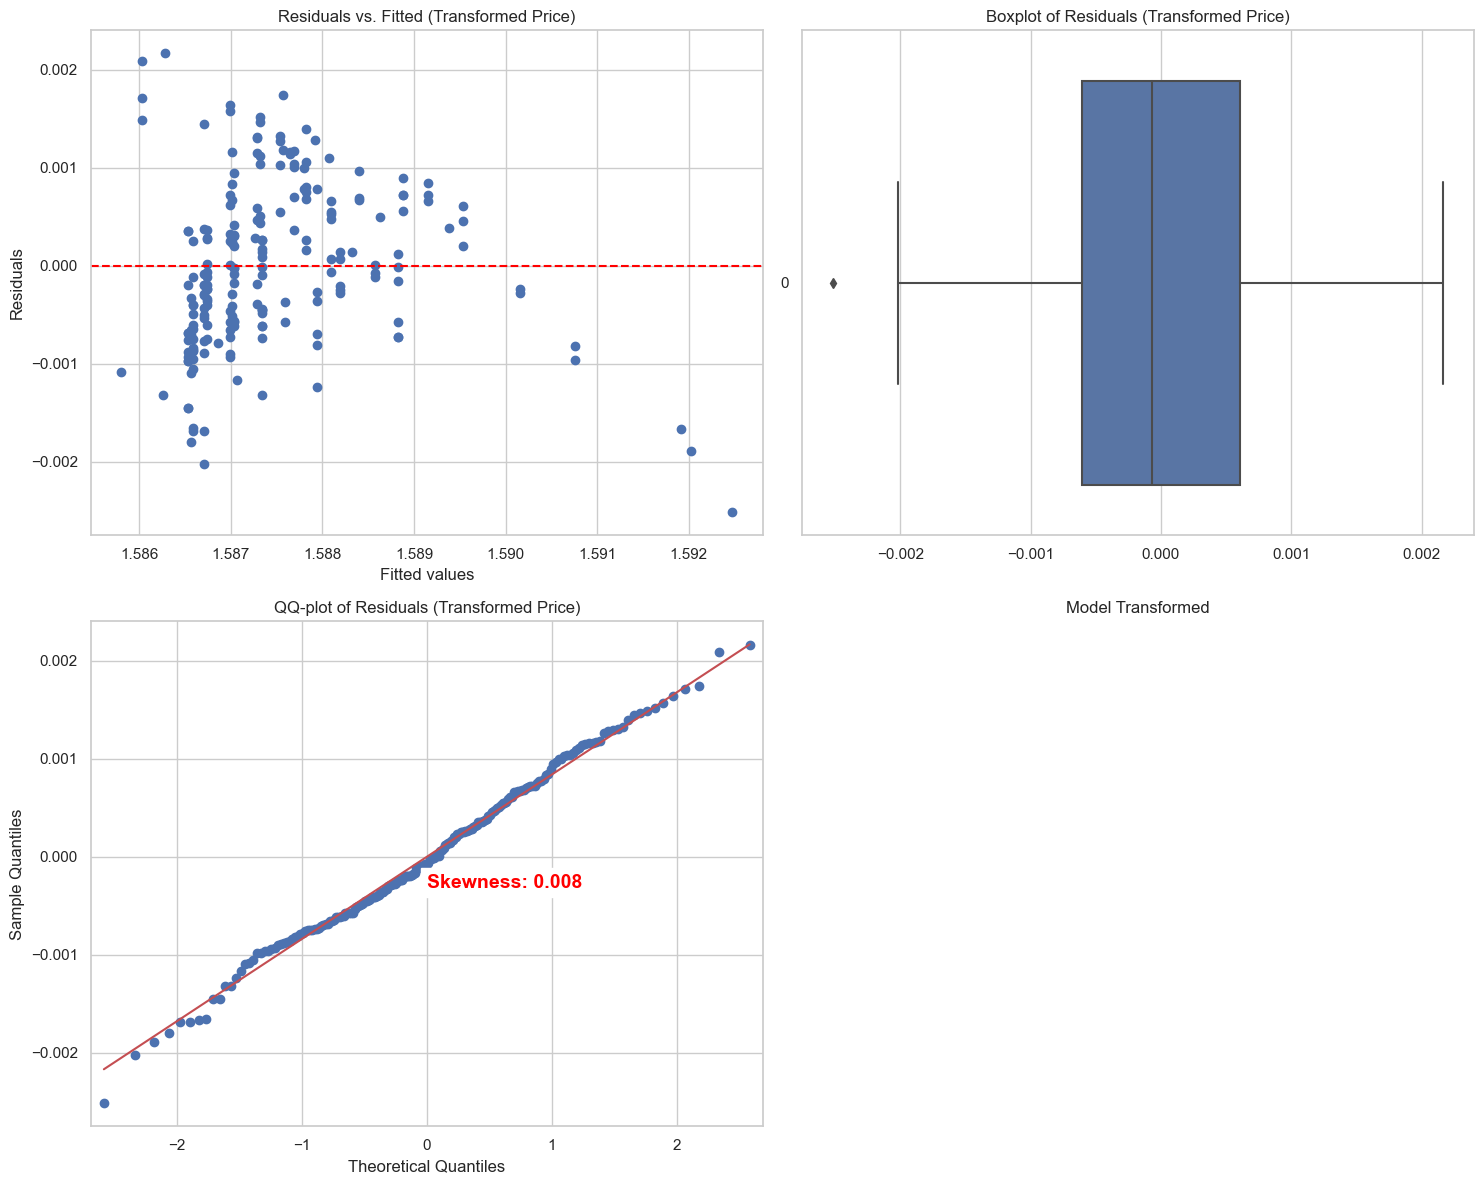

In [78]:
# Rebuild OLS model using the transformed price data
y_transformed = price_transformed
X = sm.add_constant(df2['enginesize'])  # Predictor with constant added

# Build the new OLS model
model_transformed = sm.OLS(y_transformed, X).fit()

# Get the new residuals
residuals_transformed = model_transformed.resid

# Plotting for regression diagnostics with transformed data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot between residuals and fitted values for transformed data
axes[0, 0].scatter(model_transformed.fittedvalues, residuals_transformed)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs. Fitted (Transformed Price)')

# 2. Boxplot of residuals for transformed data
sns.boxplot(residuals_transformed, ax=axes[0, 1], orient='h')
axes[0, 1].set_title('Boxplot of Residuals (Transformed Price)')

# 3. QQ-plot of residuals to check normality for transformed data
new_residuals_skewness = skew(residuals_transformed)
sm.qqplot(residuals_transformed, line='s', ax=axes[1, 0])
axes[1, 0].text(0.5, 0.5, f'Skewness: {new_residuals_skewness:.3f}',
                horizontalalignment='left', verticalalignment='top',
                fontsize=14, fontweight='bold', color='red', backgroundcolor='white',transform=axes[1, 0].transAxes)
axes[1, 0].set_title('QQ-plot of Residuals (Transformed Price)')

# 4. Calculate and display new skewness
axes[1, 1].set_title('Model Transformed')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [79]:
print(model_transformed.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     315.1
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           3.59e-43
Time:                        02:37:36   Log-Likelihood:                 1161.2
No. Observations:                 205   AIC:                            -2318.
Df Residuals:                     203   BIC:                            -2312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5843      0.000   8368.958      0.0

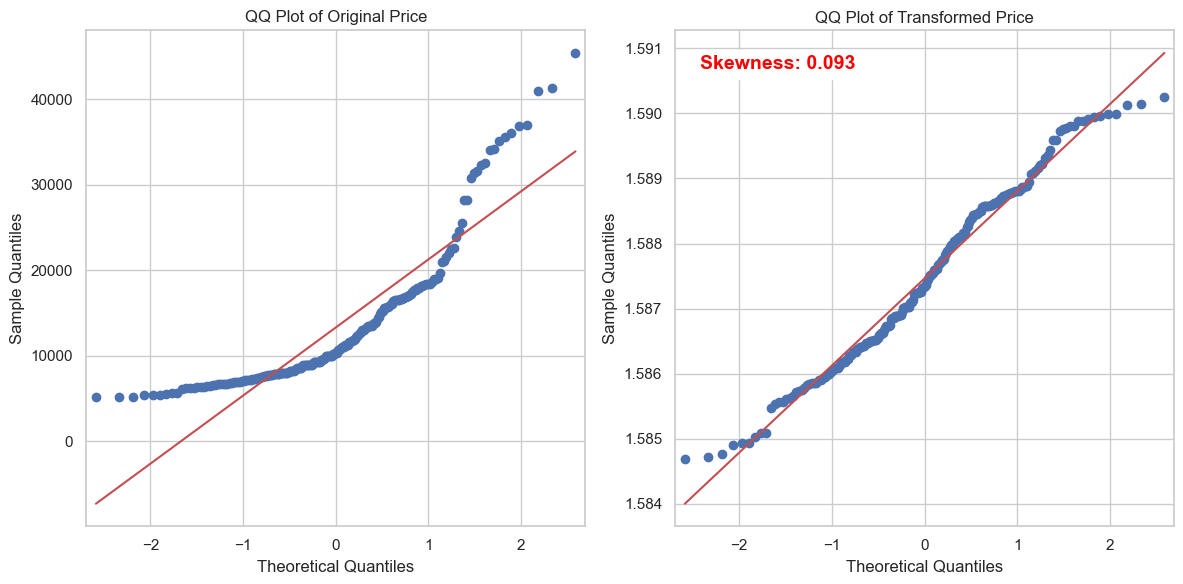

In [83]:
# Apply the cube root transformation to the 'price' column
#price_cube = np.cbrt(df2['price'])
price_transformed_skew = skew(price_transformed)
price_skewness = skew(df2['price'])
# Create QQ plots to check for normality
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# QQ plot for the original 'price' data
sm.qqplot(df2['price'], line='s', ax=ax[0])
ax[0].set_title('QQ Plot of Original Price')

# QQ plot for the cube root transformed 'price' data
sm.qqplot(price_transformed, line='s', ax=ax[1])
plt.annotate('Skewness: {:.3f}'.format(price_transformed_skew), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, 
             horizontalalignment='left', verticalalignment='top', fontweight='bold', color='red', backgroundcolor='white')
ax[1].set_title('QQ Plot of Transformed Price')

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y, y_hat)
mae = mean_absolute_error(y, y_hat)
rmse = mean_squared_error(y, y_hat, squared=False)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 14980211.054903198
Mean Absolute Error: 2815.012235414735
Root Mean Squared Error: 3870.42776123043


# Confidence Interval

In [34]:
from IPython.display import display, Latex

In [35]:
df2.mean()

wheelbase              98.756585
carlength             174.049268
carwidth               65.907805
carheight              53.724878
curbweight           2555.565854
enginesize            126.907317
boreratio               3.329756
stroke                  3.255415
compressionratio       10.142537
horsepower            104.117073
peakrpm              5125.121951
citympg                25.219512
highwaympg             30.751220
price               13276.702439
dtype: float64

In [36]:
#Function for computing Confidence Interval with 2 parameters: input data, level of confidence
def confidence_interval(data,confidence_level):
  dgf = len(data) -1
  stde_mean = stats.sem(data.iloc[:, 13])
  mean = data.mean().values[13]
  confidence_intervals = stats.t.interval(confidence_level, dgf, mean, stde_mean)
  display(Latex(f'$ {confidence_intervals[0]:,} \leq \mu \leq {confidence_intervals[1]:,}$'))

### **Level of confidence: 99%**

**Interpretation**: We are 99% confident that the true mean price of cars lies between 11,825.912147531262 and 14,727.492730517517, indicating very high precision in our estimate due to a narrow range.

In [37]:
confidence_interval(df2,0.99)

<IPython.core.display.Latex object>

Level of confidence: 95%

In [38]:
confidence_interval(df2,0.95)

<IPython.core.display.Latex object>

Level of confidence: 90%

In [39]:
confidence_interval(df2,0.90)

<IPython.core.display.Latex object>

| Confidence Level | Lower Bound      | Upper Bound      | Interpretation                                                     |
|------------------|------------------|------------------|--------------------------------------------------------------------|
| 99%              | 11,825.91        | 14,727.49        | 99% confident that the true mean price lies between these values.  |
| 95%              | 12,176.59        | 14,376.82        | 95% confident that the true mean price lies between these values.  |
| 90%              | 12,354.74        | 14,198.67        | 90% confident that the true mean price lies between these values.  |


# Hypothesis testing

In [40]:
hypothesized_mean = 15000

In [41]:
def hypothesis_test(data,null_mean,test_type,alpha):
  n = len(data)
  std = data.std().values[13]
  mean = data.mean().values[13]

  t_test = (mean - null_mean)/(std/np.sqrt(n))
  print('t =',t_test)
  if test_type.lower() in ['two-tailed','2-tailed','two_tailed','2_tailed']:
    p_value =  2*(1-t.cdf(abs(t_test), n)) # p_value for two-tail = 2 * P(T > |t|)
    print('P_value:',p_value)

  elif test_type.lower() in ['right-tailed','right-tail','righttailed','righttail']:
    p_value = 1 - t.cdf(t_test,n)     # p_value for right-tail = P(T > t) = 1 - P(T ≤ t)
    print('P_value:',p_value)

  elif test_type.lower() in ['left-tailed','left-tail','lefttailed','leftttail']:
    p_value = t.cdf(t_test,n)    # p_value for left-tail = P(T < t)
    print('P_value:',p_value)

  if p_value < alpha:
    print(f'Since P-value < {alpha}, We reject null hypothesis H0 in favor of H1')
  else:
    print(f'Since P-value > {alpha}, We failed to reject the null hypothesis.')

### Hypothesis:
* Null Hypothesis $(H_0)$: *The average price of cars is $15,000.*
* Alternative Hypothesis $(H_a)$: 
    - *The average price of cars is not $15,000. (two-tailed)*
    - *The average price of cars is higher than $15,000. (right-tailed)*
    - *The average price of cars is lower than $15,000. (left-tailed)*

### Test Statistic:

$$ t^* = \frac{\bar{x} - \mu_0}{\frac{s}{\sqrt{n}}} $$



### Decision Rule:
If $P-value < \alpha$, we conclude:

-  Reject the null hypothesis $H_0$ in favor of $H_a$.
-  Otherwise, Failed to reject the null hypothesis $H_0$.

Significant level: 0.05

In [42]:
hypothesis_test(df2,hypothesized_mean,'right-tailed',0.05)
print("Conclusion: The average price of cars is significantly higher than $15,000.")

t = -3.0885383096446613
P_value: 0.9988549552447848
Since P-value > 0.05, We failed to reject the null hypothesis.
Conclusion: The average price of cars is significantly higher than $15,000.


In [43]:
hypothesis_test(df2,hypothesized_mean,'two-tailed',0.05)
print("Conclusion: There is statistically significant evidence to conclude that the average price of cars is not $15,000.")

t = -3.0885383096446613
P_value: 0.0022900895104300822
Since P-value < 0.05, We reject null hypothesis H0 in favor of H1
Conclusion: There is statistically significant evidence to conclude that the average price of cars is not $15,000.


In [44]:
hypothesis_test(df2,hypothesized_mean,'left-tailed',0.05)
print("Conclusion: The average price of cars is significantly lower than $15,000.")

t = -3.0885383096446613
P_value: 0.0011450447552150973
Since P-value < 0.05, We reject null hypothesis H0 in favor of H1
Conclusion: The average price of cars is significantly lower than $15,000.


| Test Type         | Hypothesized Mean | Test Statistic | P-value    | Conclusion                                             |
|-------------------|-------------------|----------------|------------|--------------------------------------------------------|
| Right-tailed      | $15,000           | 0.0886         | 0.9988     | Fail to reject $H_0$. Price not significantly > $15,000 |
| Two-tailed        | $15,000           | -3.0885        | 0.0022     | Reject $H_0$. Significant evidence price ≠ $15,000     |
| Left-tailed       | $15,000           | -3.0885        | 0.0011     | Reject $H_0$. Significant evidence price < $15,000     |
